# Reading EMEP data with pyaerocom

This notebook give a short intro to reading EMEP data with pyaerocom and gives an example of running an evaluation against EBAS observations.

If you are unfamiliar with pyaerocom it is suggested to first go through the [getting started tutorial](./getting_started_setup.ipynb).

In [1]:
import pyaerocom as pya

First we make sure the pyaerocom testdata is downloaded.

In [2]:
! pya getsampledata

The testdata contains EMEP data from the 2024 report, which has been regridded to reduce file size.

## File convention

PyAerocom understands the following file conventions for EMEP data:
- Base_hour.nc - Hourly resolution
- Base_day.nc - Daily resolution
- Base_month.nc - Monthly resolution
- Base_fullrun.nc - Yearly resolution

It is expected that each file contains at most one year of data.
Each file can contain several variables. The mapping between EMEP and pyaerocom variable names is available in the [pyaerocom github repository](https://github.com/metno/pyaerocom/blob/master/pyaerocom/data/emep_variables.ini).

In [3]:
emep_dir = './data/testdata-minimal/modeldata/EMEP_1999/'

In [4]:
import os; os.listdir(emep_dir)

['Base_month.nc']

There are three available files. Two of them are in the file convention that PyAerocom understands, in daily and monthly resolution.

## Reading conventionally named data

We start by reading the data with the PyAerocom-friendly convention.<br>
Initialize reader and point it to the right folder:

In [5]:
reader = pya.io.mscw_ctm.reader.ReadMscwCtm(data_id='EMEP', data_dir=emep_dir,)
print(reader)

ReadMscwCtm


In [6]:
reader.years_avail

['1999']

Both files are from 2017.<br>
We can read one of the variables and make a basic map.<br>
Note that we specify the temporal resolution with ts_type, which will ensure the right file is loaded.

In [7]:
data = reader.read_var('concpm10', ts_type='monthly')
data

pyaerocom.GriddedData: (concpm10, EMEP)
<iris 'Cube' of concpm10 / (ug/m3) (time: 12; latitude: 150; longitude: 210)>

Data is a GriddedData object, see more in the [getting started tutorial.](./getting_started_analysis.ipynb)

/home/danielh/Documents/environments/pya_dev/lib/python3.10/site-packages/iris/coords.py:1978: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/home/danielh/Documents/environments/pya_dev/lib/python3.10/site-packages/iris/coords.py:1978: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


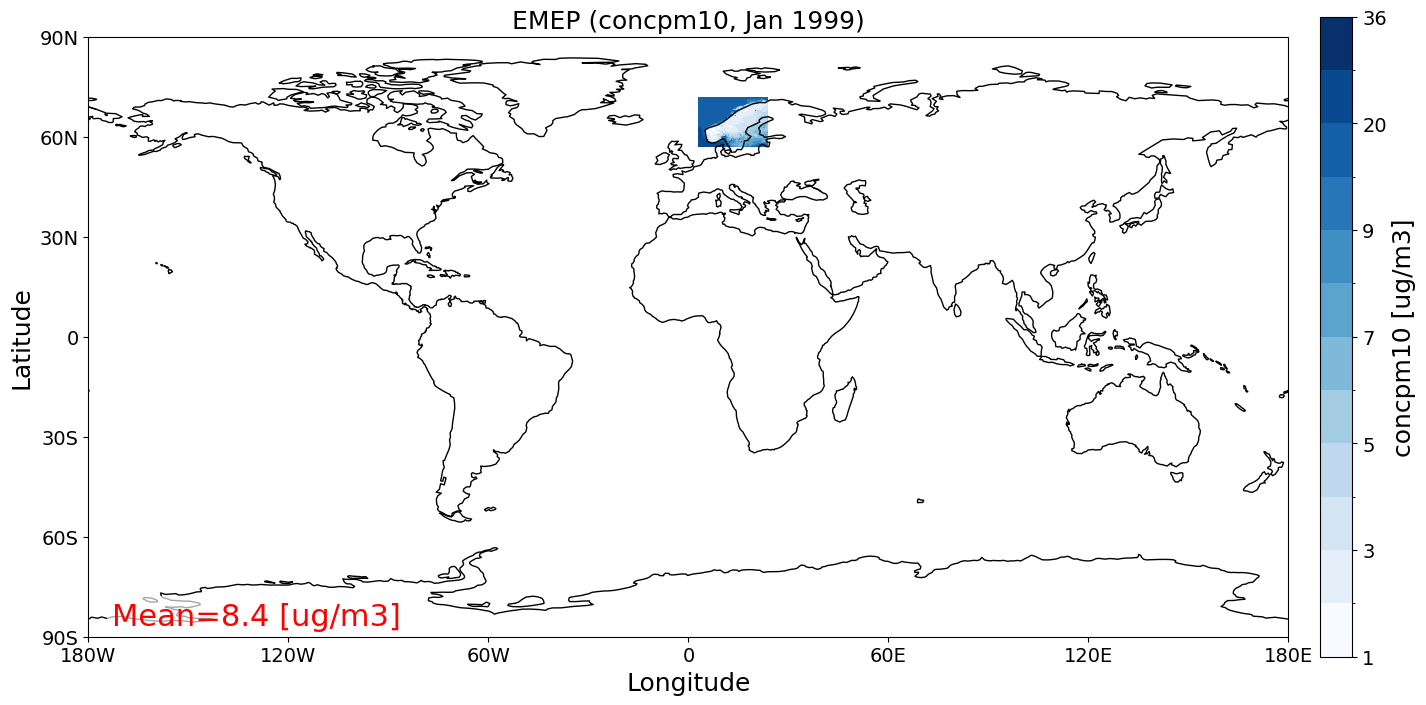

In [8]:
data.quickplot_map(0);

## Colocating data

The testdata contains both the EMEP example data and a subset of the EBAS dataset. To make sure PyAerocom knows how to use the EBAS subset, we must add it

In [9]:
pya.const.add_ungridded_obs(obs_id="EBASSubset", data_dir="./data/testdata-minimal/obsdata/EBASMultiColumn",reader=pya.io.ReadEbas)

We have now added an ungridded observation network with the name `EBASSubset`, which is read with the EBAS reader supplied by PyAerocom

Load the EBAS concpm10 data.

In [10]:
var_name='concpm10'
r = pya.io.ReadUngridded('EBASSubset')
data_ebas = r.read(vars_to_retrieve=var_name)
data_ebas

UngriddedData <networks: ['EBASSubset']; vars: ['concpm10']; instruments: ['digitel_1', 'rad_cz03', 'b_att_01', 'hvs_no01', 'kfg_0058', 'filterpack_US0065', 'filterpack_US2098']; No. of metadata units: 7

Plot timeseries for Birkenes II.

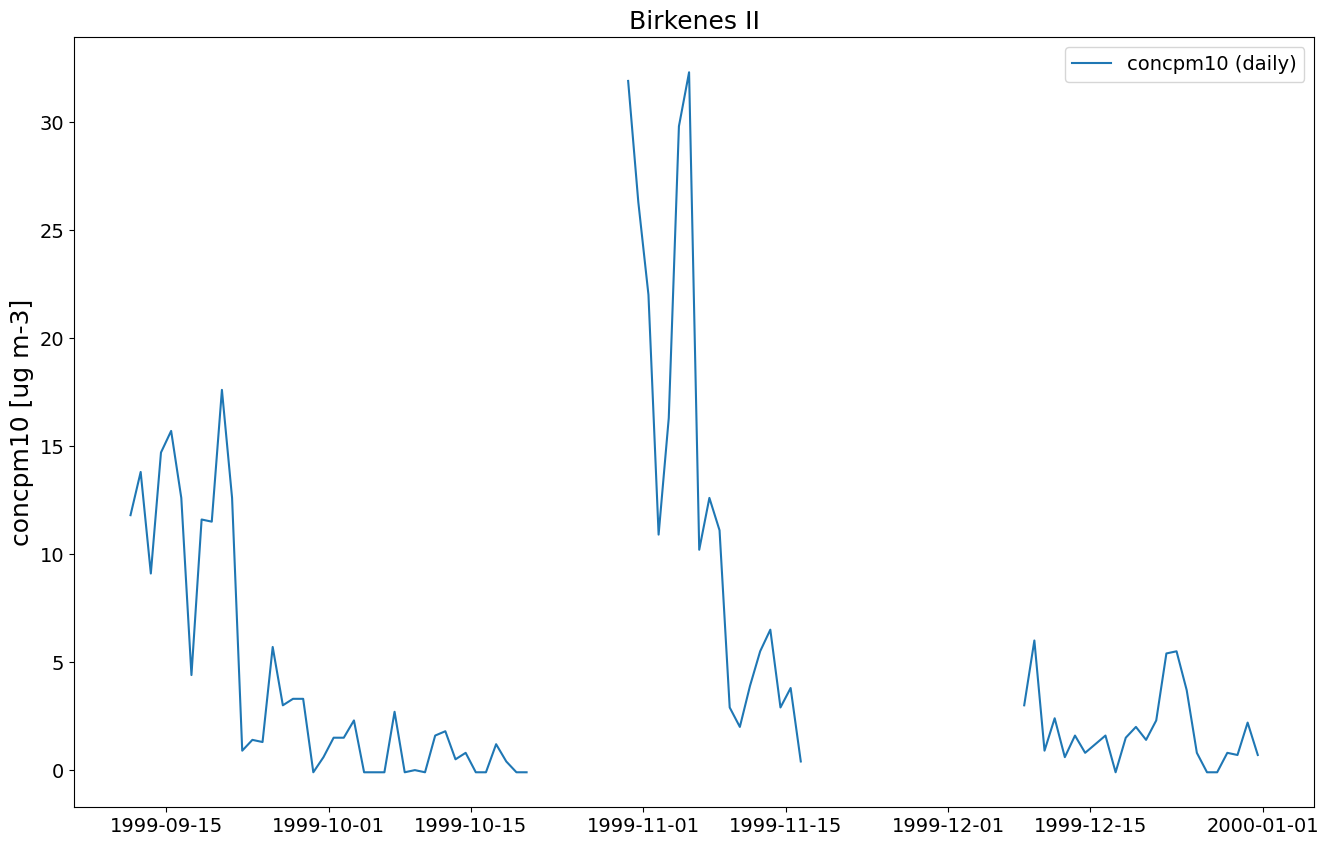

In [11]:
data_ebas.plot_station_timeseries("Birkenes II", var_name=var_name);

e can now look at how to colocate EMEP with out EBASSubset. We start by making a `ColocatonSetup` see [the documentation](https://pyaerocom.readthedocs.io/en/latest/api.html#pyaerocom.colocation.colocation_setup.ColocationSetup) for more information

In [12]:
colocatorsetup = pya.ColocationSetup(
    model_id="EMEP", obs_id="EBASSubset", obs_vars='concpm10',
    model_data_dir=emep_dir,
    gridded_reader_id={"model": "ReadMscwCtm"},
    ts_type='monthly', 
    model_ts_type_read='monthly',
    
    reanalyse_existing=True, 
    
    start="1999-01-01",
    stop="2000-01-01"
)

colocatorsetup

ColocationSetup(model_id='EMEP', obs_id='EBASSubset', obs_vars=('concpm10',), ts_type='monthly', start=Timestamp('1999-01-01 00:00:00'), stop=Timestamp('2000-01-01 00:00:00'), obs_config=None, OBS_VERT_TYPES_ALT={'Surface': 'ModelLevel', '2D': '2D'}, CRASH_ON_INVALID=False, FORBIDDEN_KEYS=['var_outlier_ranges', 'var_ref_outlier_ranges', 'remove_outliers'], filter_name='ALL-wMOUNTAINS', basedir_coldata='/home/danielh/MyPyaerocom/colocated_data', save_coldata=False, obs_name=None, obs_data_dir=None, obs_use_climatology=False, obs_cache_only=False, obs_vert_type=None, obs_ts_type_read=None, obs_filters={}, colocation_layer_limits=None, profile_layer_limits=None, read_opts_ungridded={}, model_name=None, model_data_dir='./data/testdata-minimal/modeldata/EMEP_1999/', model_read_opts={}, model_use_vars={}, model_rename_vars={}, model_add_vars={}, model_to_stp=False, model_ts_type_read='monthly', model_read_aux={}, model_use_climatology=False, gridded_reader_id={'model': 'ReadMscwCtm'}, flex_t

In [13]:
colocator = pya.Colocator(colocatorsetup)
colocator

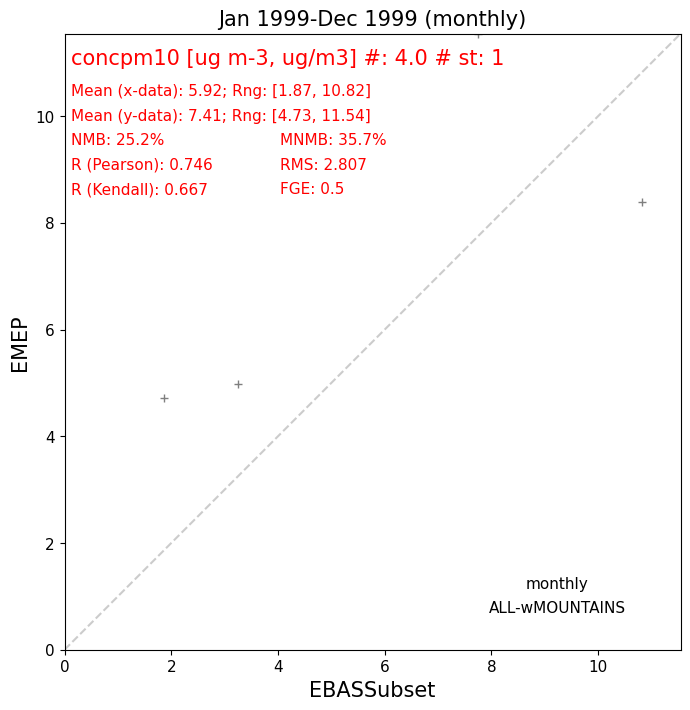

In [14]:
colocator.run()
colocator.data["concpm10"]["concpm10"].plot_scatter();

And we get a scatter plot and statistics of the colocated data.<br>